In [ ]:
# | default_exp classic_mlp

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import equinox as eqx
from jax import random
from jax.random import PRNGKey, split
from jax import jit, grad
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='icefire', font='serif',
            font_scale=1, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [ ]:
# | export

class Model(eqx.Module):
    layers: list

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

In [ ]:
# | export

def MLP(layer_sizes, key):
    keys = split(key, len(layer_sizes) - 1)
    layers = [
        eqx.nn.Linear(in_size, out_size, key=k)
        for in_size, out_size, k in zip(layer_sizes[:-1], layer_sizes[1:], keys)
    ]
    return Model(layers)

In [ ]:
# | export

@eqx.filter_value_and_grad()
def compute_loss(params, x, y):
    preds = jax.vmap(params)(x)
    return jnp.mean((preds - y) ** 2)

In [ ]:
# | export

@eqx.filter_jit
def train_step(params, x, y, opt_state, opt_update):
    loss, grads = compute_loss(params, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    return loss, params, opt_state

In [ ]:
def generate_data(num_samples):
    x = jnp.linspace(0, 2 * jnp.pi, num_samples)
    y_sin = jnp.sin(x)
    y_cos = jnp.cos(x)
    # return y_sin.reshape(-1, 1), y_cos.reshape(-1, 1)
    return x.reshape(-1,1), y_sin.reshape(-1, 1)

[<matplotlib.lines.Line2D>]

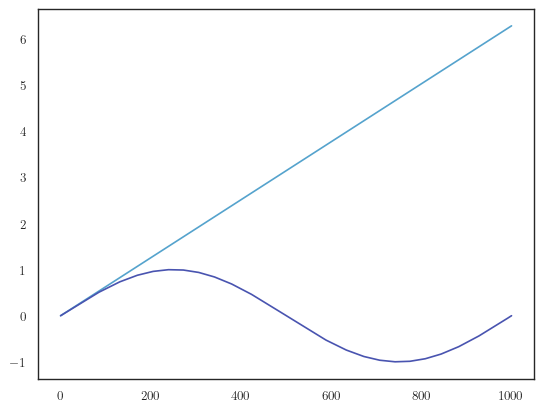

In [ ]:
sin, cos = generate_data(1000)
plt.plot(sin)
plt.plot(cos)

In [ ]:
# Main training function
def train_mlp(num_epochs=1000, learning_rate=0.01):
    key = random.PRNGKey(42)
    layer_sizes = [1, 16, 1]  # Input layer, two hidden layers, and output layer
    model = MLP(layer_sizes, key)
    opt = optax.adabelief(learning_rate)
    opt_state = opt.init(model)
    loss_history = []

    # Generate training data
    x_train, y_train = generate_data(1000)

    # Training loop
    for epoch in range(num_epochs):
        loss, model, opt_state = train_step(model, x_train, y_train, opt_state, opt.update)
        loss_history.append(loss)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss}')

    return model, loss_history


In [ ]:
model, loss_history = train_mlp(num_epochs=2000)
n_nodes = model.layers[0].in_features + sum([layer.out_features for layer in model.layers]) 
node_history = [n_nodes] * len(loss_history)

Epoch 100, Loss: 0.10407068958443069
Epoch 200, Loss: 0.06511103046370334
Epoch 300, Loss: 0.03950989925661426
Epoch 400, Loss: 0.016313792906488288
Epoch 500, Loss: 0.003989728896102038
Epoch 600, Loss: 0.0013218410034057998
Epoch 700, Loss: 0.000687721534098036
Epoch 800, Loss: 0.0004909629608015066
Epoch 900, Loss: 0.0003976312010316753
Epoch 1000, Loss: 0.0003604691480352124
Epoch 1100, Loss: 0.00038664587139428054
Epoch 1200, Loss: 0.0003351048107744733
Epoch 1300, Loss: 0.00032820450242027305
Epoch 1400, Loss: 0.0003370917236067549
Epoch 1500, Loss: 0.00032130465744799666
Epoch 1600, Loss: 0.00031814610807300475
Epoch 1700, Loss: 0.000328458544254346
Epoch 1800, Loss: 0.0003135279165720657
Epoch 1900, Loss: 0.00032174398337807725
Epoch 2000, Loss: 0.0003096719357126386


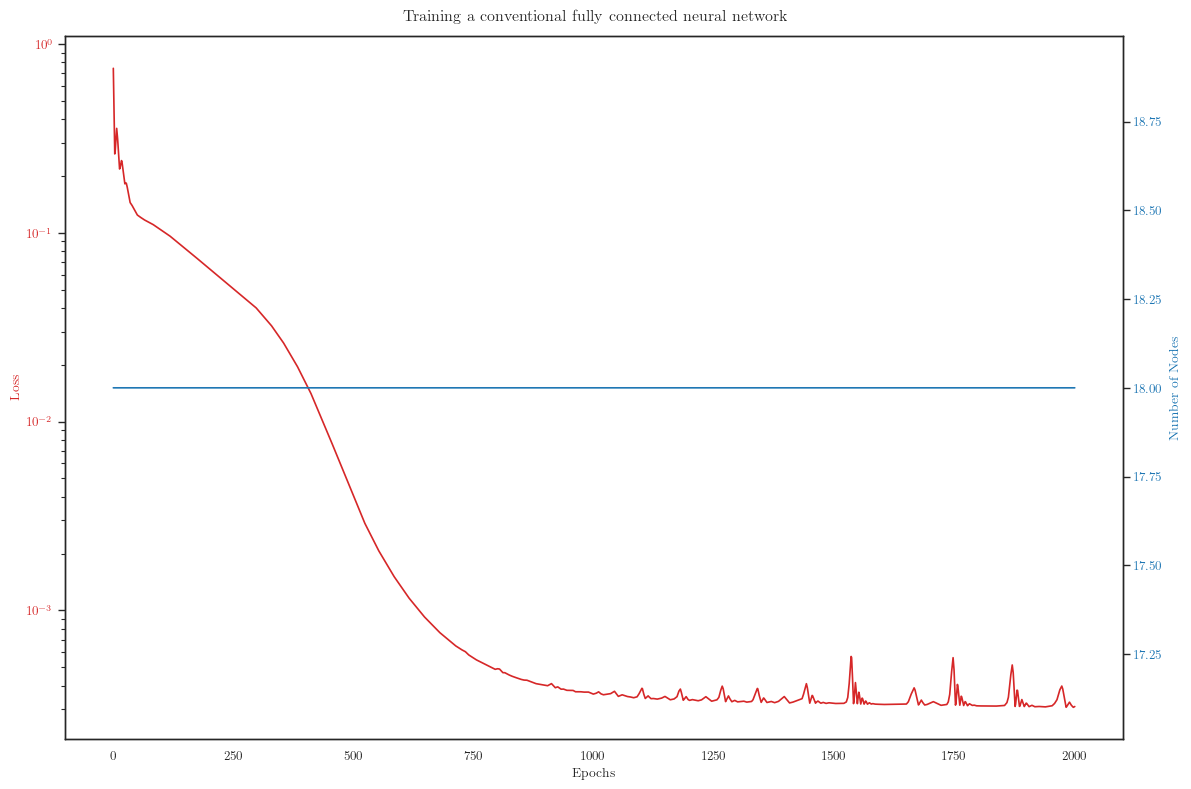

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))
num_epochs = len(loss_history)
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,num_epochs), loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,num_epochs), node_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Training a conventional fully connected neural network")
fig.tight_layout()

In [ ]:
# Evaluate the trained model
def evaluate_mlp(model):
    x_test, y_test = generate_data(100)
    y_pred = jax.vmap(model)(x_test)
    return x_test, y_test, y_pred

In [ ]:
x_test, y_test, y_pred = evaluate_mlp(model)

In [ ]:
# Plot the results
def plot_results(x, y_true, y_pred):
    plt.axes().set_aspect('equal')
    plt.plot(x, y_true, "." ,label='True cos(x)')
    plt.plot(x, y_pred, "." ,label='Predicted cos(x)')
    
    plt.legend()
    plt.show()

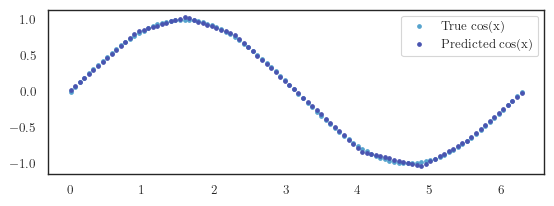

In [ ]:
plot_results(x_test, y_test, y_pred)